# EDA Sentiment Analyses 

In [1]:
# Importing the Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords 
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import re
import string
from string import punctuation
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer 

from sklearn.preprocessing import LabelEncoder 
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

stop_words = set(stopwords.words('english'))
punctuation = punctuation + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&o' 


In [2]:
#UCI ML drug dataset

#Importing the datasets

df_train = pd.read_csv("drugsComTrain_raw.csv")
df_test = pd.read_csv("drugsComTest_raw.csv") 

print ("The shape of the train set given is : ", df_train.shape)
print ("The shape of the test set given is : ", df_test.shape)

df_train.head()

The shape of the train set given is :  (161297, 7)
The shape of the test set given is :  (53766, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [3]:
# Data types
df_train.dtypes 

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [4]:
#Merging the test and train data 
merge = [df_train, df_test]
df_data = pd.concat(merge)

print (df_data.shape)

df_data.head(10)

(215063, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [5]:
df_data.describe()

,uniqueID,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [10]:
# Null values
print ("Null values in the dataset : ", df_data.isnull().sum(axis = 0))

Null values in the dataset :  uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64


In [11]:
df_data.describe() 

,uniqueID,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [12]:
# Calculating what percentage of data is null 

size = df_data.shape[0] 

print("Total Size of the dataset : ", size)  

total_na = df_data.isnull().sum(axis=0)['condition'] 
print("Null values", total_na) 

print("Percentage of null values : ", (total_na/size)*100)  

Total Size of the dataset :  215063
Null values 1194
Percentage of null values :  0.5551861547546533


In [13]:
# Dropping the data points with null values as it's very much less than 5% of the total data points and also the data is not time series data 
# so we can drop the data points with null values without any problem 
df_data  = df_data.dropna(how='any',axis=0)  
print("The shape of the data after dropping the null values is : ",df_data.shape) # printing the shape of the data after dropping the null values 

The shape of the data after dropping the null values is :  (213869, 7)


In [14]:
# lowercasing the column names so it will be easier to work with them 
df_data.columns = df_data.columns.str.lower()  

In [15]:
df_data.columns

Index(['uniqueid', 'drugname', 'condition', 'review', 'rating', 'date',
       'usefulcount'],
      dtype='object')

In [16]:
# Sorting the dataframe by uniqueID 
df_data = df_data.sort_values(by=['uniqueid'])  
df_data.reset_index(inplace=True, drop=True) 
df_data.head(10) 

,uniqueid,drugname,condition,review,rating,date,usefulcount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,27-Oct-15,11
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,26-Oct-15,12
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,25-Oct-15,4
5,6,Medroxyprogesterone,Birth Control,"""This is a horrible shot!! I got my first shot...",1,24-Oct-15,3
6,7,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 18 and got this for heavy bleeding. ...",5,22-Oct-15,6
7,8,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Im 19 and have been having heavy and painful ...",5,21-Oct-15,2
8,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,21-Oct-15,5
9,10,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 years old and I got shot in Augus...",7,20-Oct-15,2


In [17]:
# Total unique conditions in the dataset 
print(df_data['condition'].nunique(), "\n") 
print("some of the conditions are: \n", df_data['condition'].unique()[0:10], "\n")  

916 

some of the conditions are: 
 ['Abnormal Uterine Bleeding' 'Amenorrhea' 'Birth Control' 'Endometriosis'
 'Endometrial Hyperplasia, Prophylaxis' 'Renal Cell Carcinoma'
 'Not Listed / Othe' 'Eye Redness' 'Benign Prostatic Hyperplasia' 'Acne'] 



In [18]:
# top 10 drugs with rating equals 1  
df_data[df_data['rating']==1]['drugname'].value_counts().head(10) 

drugname
Miconazole                            767
Ethinyl estradiol / norethindrone     728
Etonogestrel                          707
Levonorgestrel                        511
Nexplanon                             504
Ethinyl estradiol / norgestimate      464
Medroxyprogesterone                   443
Depo-Provera                          417
Tioconazole                           410
Ethinyl estradiol / levonorgestrel    385
Name: count, dtype: int64

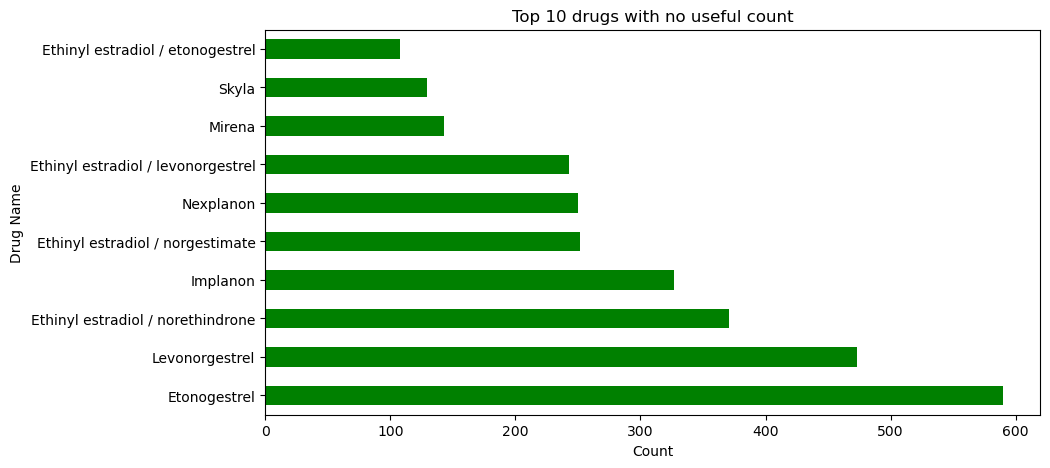

In [19]:
df_data.loc[df_data.usefulcount==0, 'drugname'].value_counts()[:10].plot(kind='barh', figsize=(10,5), color='green') 
plt.title('Top 10 drugs with no useful count') 
plt.xlabel('Count')
plt.ylabel('Drug Name')
plt.show() 

In [20]:
# minimum rating in the dataset 
min_rating = min(df_data['rating']) 
print(min_rating)  

1


In [21]:
# Converting the date in to date time format 
df_data['date'] = pd.to_datetime(df_data['date']) 

# Exploratory Data Analysis 

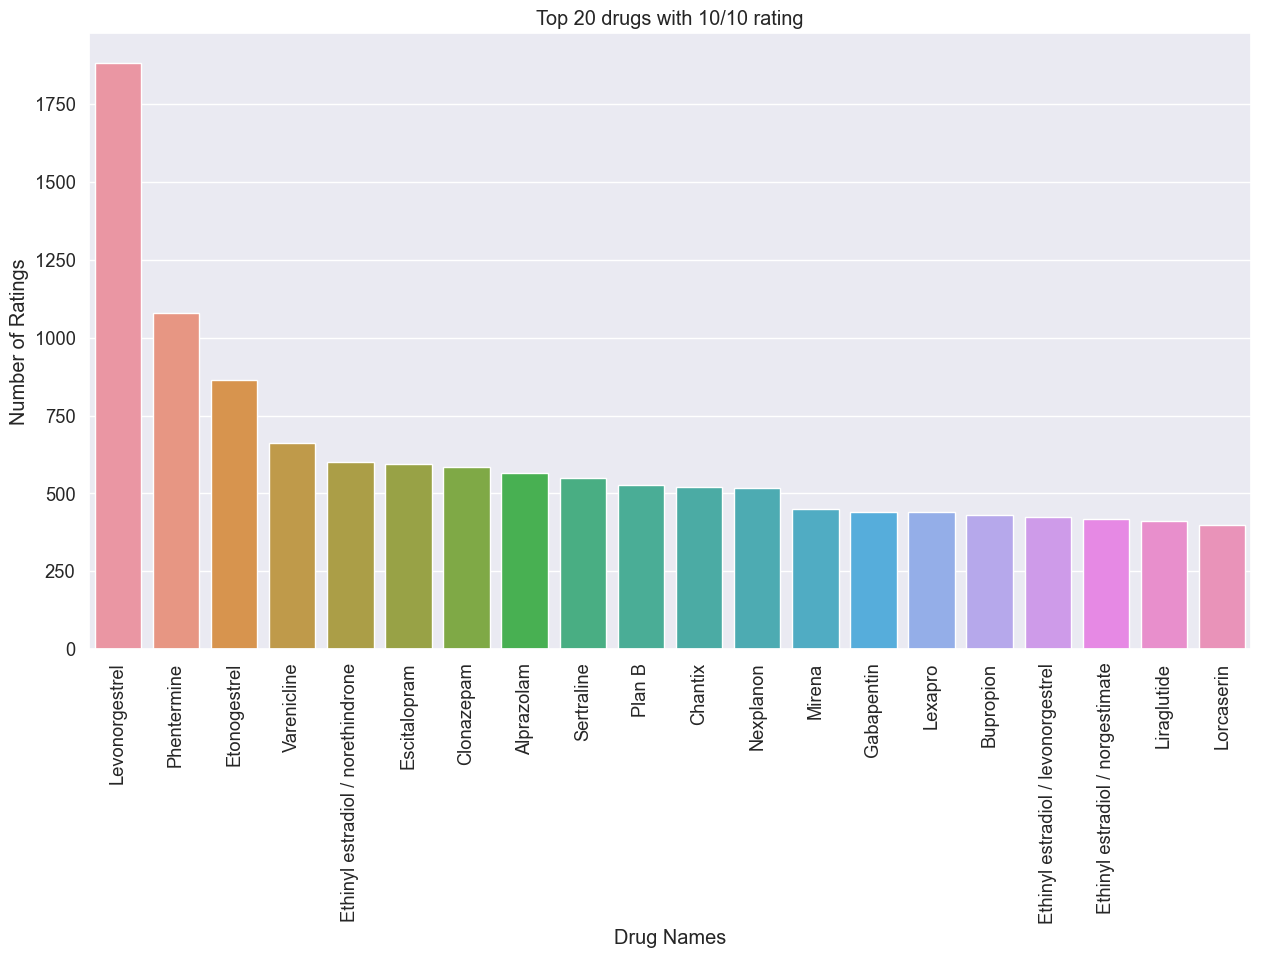

In [22]:
# This barplot shows the top 20 drugs with the 10/10 rating

# Setting the Parameters
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df_data.loc[df_data.rating == 10, "drugname"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set(title = 'Top 20 drugs with 10/10 rating', ylabel = 'Number of Ratings', xlabel = "Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90); # Rotating the x-axis labels to 90 degrees 

Text(0.5, 0, 'Drug name')

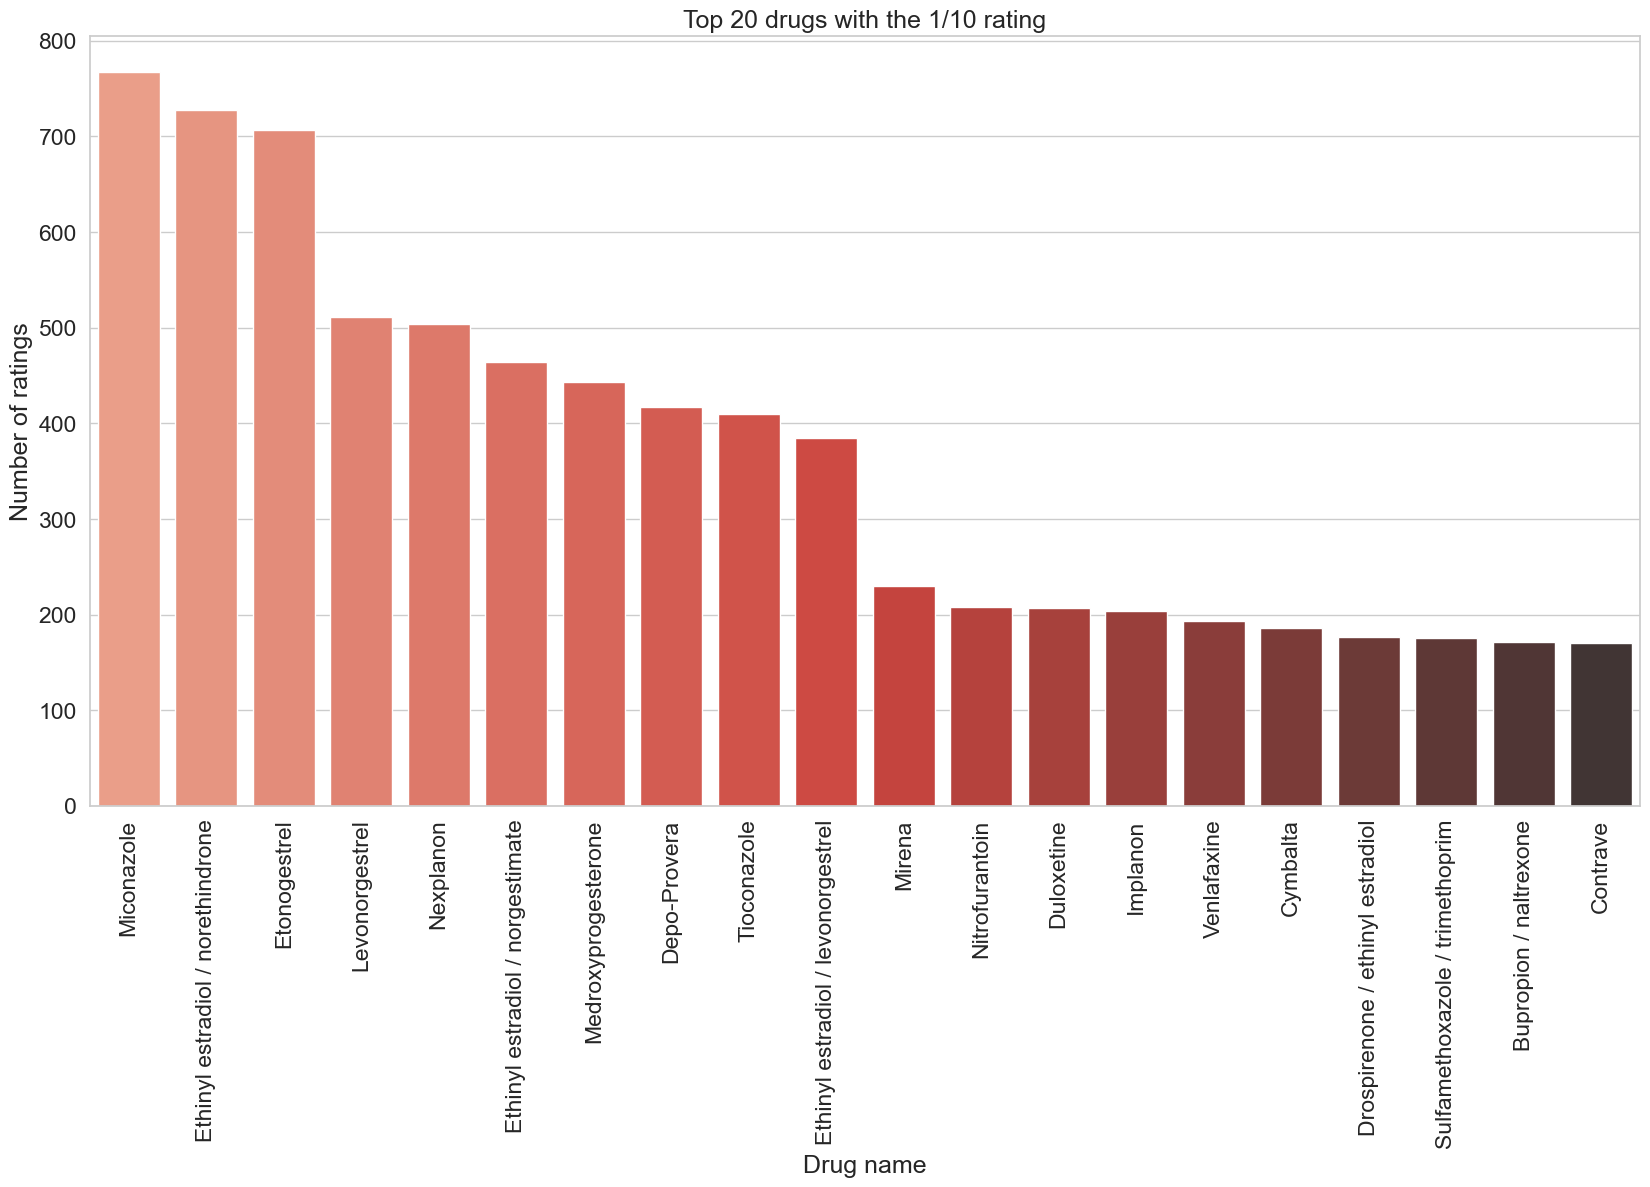

In [25]:
# This barplot shows the Top 20 drugs with the 1/10 rating 

# setting parameter 
sns.set(font_scale=1.5, style="whitegrid") 
plt.rcParams['figure.figsize'] = (20, 10) 

rating = dict(df_data.loc[df_data.rating==1, 'drugname'].value_counts()) 

drugname = list(rating.keys()) 

sns_rating = sns.barplot(x=drugname[:20], y=list(rating.values())[:20], palette="Reds_d") 
sns_rating.set_xticklabels(sns_rating.get_xticklabels(), rotation=90) 
sns_rating.set_title("Top 20 drugs with the 1/10 rating") 
sns_rating.set_ylabel("Number of ratings") 
sns_rating.set_xlabel("Drug name") 

Text(0.5, 0, 'Ratings')

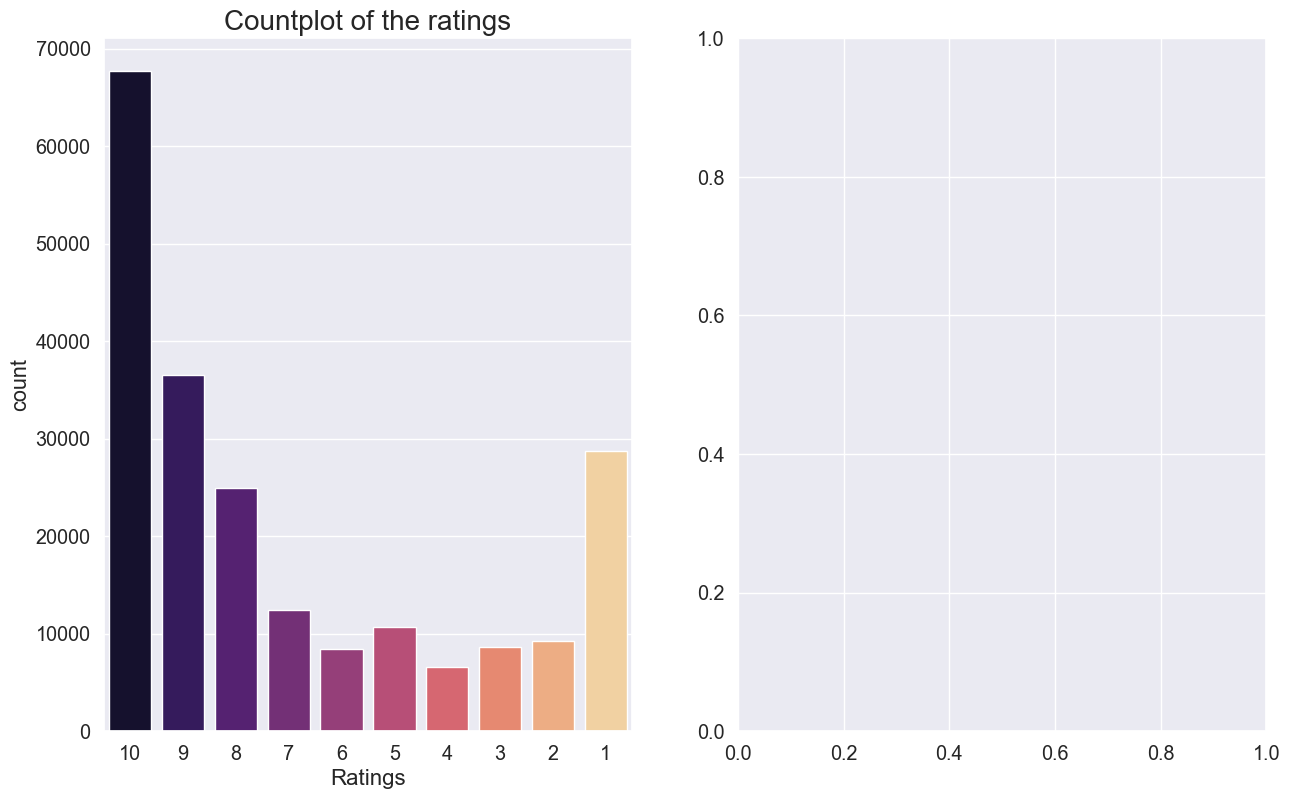

In [31]:
# A counplot of the ratings so we can see the distribution of the ratings in the dataset 
plt.rcParams['figure.figsize'] = (15, 9) # setting the figure size 
sns.set(style = 'darkgrid', font_scale = 1.3) # setting the style of the plot and the font size 
fig, ax = plt.subplots(1, 2) # creating a figure and axes object  

sns_1 = sns.countplot(df_data['rating'], palette='magma', order=list(range(10, 0, -1)), ax=ax[0]) # creating a countplot for the ratings 
sns_1.set_title('Countplot of the ratings', fontsize=20) # setting the title of the plot 
sns_1.set_xlabel('Ratings', fontsize=16) # setting the x label of the plot

#sns_2 = sns.displot(df_data['rating']) # creating a distplot for the ratings 
#sns_2.set_title('Distplot of the ratings', fontsize=20) # setting the title of the plot 
#sns_2.set_xlabel('Ratings', fontsize=16) # setting the x label of the plot 
